In [19]:
import numpy as np
import tensorflow as tf
import gpflow
import time

from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression
from trieste.models.interfaces import TrainablePredictJointReparamModelStack
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE

from trieste.acquisition import BatchMonteCarloExpectedHypervolumeImprovement, Fantasizer, ExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer

from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point


from test_functions import HartmannAckley6D
from mo_penalization import MOLocalPenalizationAcquisitionFunction
from generate_true_pareto_fronts import read_true_pf

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
test_function = HartmannAckley6D()

In [29]:
true_pf = test_function.scale(read_true_pf(test_function.true_pf_filename))

In [30]:
observer = mk_observer(test_function, OBJECTIVE)

In [31]:
def build_stacked_independent_objectives_model(data, n_obj):
    gprs = []
    for idx in range(n_obj):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance, tf.constant(0.2, tf.float64))
        gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return TrainablePredictJointReparamModelStack(*gprs)


## MO LP

Repeat #1


2022-02-03 09:51:47.407552: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-03 09:51:48.449955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-03 09:51:48.457703: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2207995000 Hz


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Optimization completed without errors
Finished in 61.886260747909546s


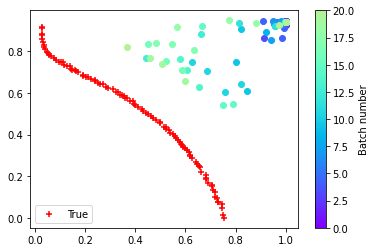

Repeat #2
Optimization completed without errors
Finished in 62.921321630477905s


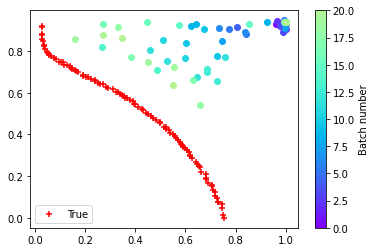

Repeat #3
Optimization completed without errors
Finished in 61.29701256752014s


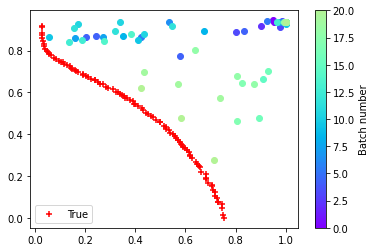

Repeat #4
Optimization completed without errors
Finished in 64.5471613407135s


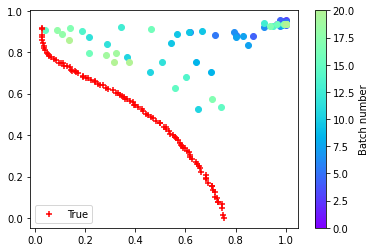

Repeat #5
Optimization completed without errors
Finished in 63.18526744842529s


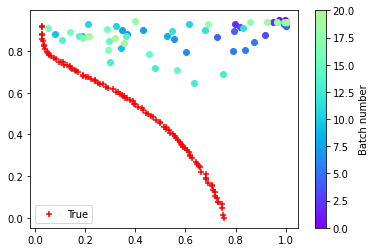

In [32]:
n_initial_points = 6
n_query_points = 4
n_optimization_steps = 20
n_repeats = 5

import matplotlib
from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 0.6, n_optimization_steps))
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(cm.rainbow, maxval=0.6)
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_optimization_steps)



hv_regret = []
j = 0
times = []
while j < n_repeats:
    print(f"Repeat #{j+1}")
    initial_query_points = test_function.search_space.sample(n_initial_points)
    initial_data = observer(initial_query_points)

    model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE], test_function.n_objectives)
    acq_fn = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
    acq_rule = EfficientGlobalOptimization(acq_fn, num_query_points=n_query_points)

    start = time.time()
    result = BayesianOptimizer(observer, test_function.search_space).optimize(n_optimization_steps,
                                                                            initial_data,
                                                                            {OBJECTIVE: model},
                                                                            acq_rule)
    stop = time.time()
    print(f"Finished in {stop - start}s")

    dataset = result.try_get_final_datasets()[OBJECTIVE]
    j += 1

    for i in range(0, n_optimization_steps):
        start = n_initial_points + i*n_query_points
        end = n_initial_points + (i+1)*n_query_points
        plt.scatter(dataset.observations[start:end, 0], dataset.observations[start:end, 1], color=colors[i])
    plt.scatter(true_pf[:,0], true_pf[:,1], marker='+', c='r', label="True")
    plt.legend()
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', label='Batch number')
    plt.show();

## KB for comparison

Repeat #1
Optimization completed without errors
Finished in 214.48382949829102s


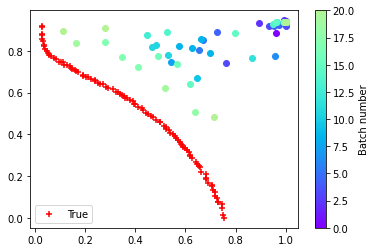

Repeat #2
Optimization completed without errors
Finished in 208.5203025341034s


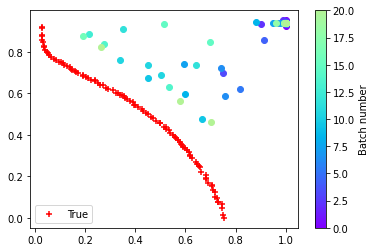

Repeat #3
Optimization completed without errors
Finished in 241.90972352027893s


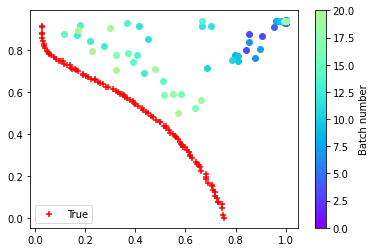

Repeat #4


KeyboardInterrupt: 

In [33]:
n_initial_points = 6
n_query_points = 4
n_optimization_steps = 20
n_repeats = 5

import matplotlib
from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 0.6, n_optimization_steps))
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(cm.rainbow, maxval=0.6)
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_optimization_steps)



hv_regret = []
j = 0
times = []
while j < n_repeats:
    print(f"Repeat #{j+1}")
    initial_query_points = test_function.search_space.sample(n_initial_points)
    initial_data = observer(initial_query_points)

    model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE], test_function.n_objectives)
    acq_fn = Fantasizer(ExpectedHypervolumeImprovement())
    acq_rule = EfficientGlobalOptimization(acq_fn, num_query_points=n_query_points)

    start = time.time()
    result = BayesianOptimizer(observer, test_function.search_space).optimize(n_optimization_steps,
                                                                            initial_data,
                                                                            {OBJECTIVE: model},
                                                                            acq_rule)
    stop = time.time()
    print(f"Finished in {stop - start}s")

    dataset = result.try_get_final_datasets()[OBJECTIVE]
    j += 1

    for i in range(0, n_optimization_steps):
        start = n_initial_points + i*n_query_points
        end = n_initial_points + (i+1)*n_query_points
        plt.scatter(dataset.observations[start:end, 0], dataset.observations[start:end, 1], color=colors[i])
    plt.scatter(true_pf[:,0], true_pf[:,1], marker='+', c='r', label="True")
    plt.legend()
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', label='Batch number')
    plt.show();

## What will MO LP do with many more iterations?

Repeat #1
Optimization completed without errors
Finished in 198.31492352485657s


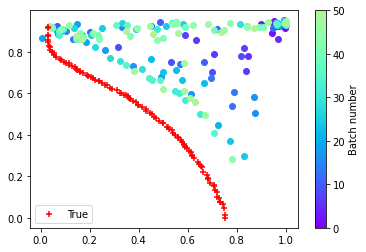

In [34]:
n_initial_points = 6
n_query_points = 4
n_optimization_steps = 50
n_repeats = 1

import matplotlib
from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 0.6, n_optimization_steps))
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(cm.rainbow, maxval=0.6)
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_optimization_steps)



hv_regret = []
j = 0
times = []
while j < n_repeats:
    print(f"Repeat #{j+1}")
    initial_query_points = test_function.search_space.sample(n_initial_points)
    initial_data = observer(initial_query_points)

    model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE], test_function.n_objectives)
    acq_fn = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
    acq_rule = EfficientGlobalOptimization(acq_fn, num_query_points=n_query_points)

    start = time.time()
    result = BayesianOptimizer(observer, test_function.search_space).optimize(n_optimization_steps,
                                                                            initial_data,
                                                                            {OBJECTIVE: model},
                                                                            acq_rule)
    stop = time.time()
    print(f"Finished in {stop - start}s")

    dataset = result.try_get_final_datasets()[OBJECTIVE]
    j += 1

    for i in range(0, n_optimization_steps):
        start = n_initial_points + i*n_query_points
        end = n_initial_points + (i+1)*n_query_points
        plt.scatter(dataset.observations[start:end, 0], dataset.observations[start:end, 1], color=colors[i])
    plt.scatter(true_pf[:,0], true_pf[:,1], marker='+', c='r', label="True")
    plt.legend()
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', label='Batch number')
    plt.show();